In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
# Parámetros del dominio
a = 2.0  # Altura del canal (m)
b = 5.0  # Ancho del canal (m)
d = 1.0  # Distancia del obstáculo a la entrada (m)
u0 = 1.0  # Velocidad de entrada (m/s)
nu = 0.1  # Viscosidad cinemática (m^2/s)

# Parámetros de la malla
n = 50  # Número de puntos en la dirección y (vertical)
m = 100  # Número de puntos en la dirección x (horizontal)
dx = b / m  # Tamaño de celda en x
dy = a / n  # Tamaño de celda en y
dt = 0.001  # Paso de tiempo
T = 5.0  # Tiempo de simulación total
N = int(T / dt)  # Número de pasos en el tiempo

# Parámetros físicos
rho = 1.0  # Densidad del fluido (kg/m^3)

# Definir el obstáculo circular
r = a / 25  # Radio del obstáculo
obstacle_center = (d, a / 2)  # Centro del obstáculo (a lo largo del eje x y en la mitad del canal)


In [3]:
# Matrices de velocidades y presión
u = np.zeros((n, m))  # Velocidad en x
v = np.zeros((n, m))  # Velocidad en y
p = np.zeros((n, m))  # Presión

# Matriz b para la ecuación de Poisson
b = np.zeros((n, m))

# Condiciones de borde: velocidad en IN y en las paredes
u[:, 0] = u0  # Velocidad constante en la entrada (IN)
u[:, -1] = 0  # Velocidad nula en la salida (OUT)

# Condiciones en las paredes móviles
u[0, :] = u0  # Pared superior
u[-1, :] = u0  # Pared inferior

# Establecer el obstáculo: velocidad cero en la región del obstáculo
for i in range(n):
    for j in range(m):
        x, y = j * dx, i * dy
        if (x - obstacle_center[0])**2 + (y - obstacle_center[1])**2 < r**2:
            u[i, j] = 0
            v[i, j] = 0


In [4]:
# Actualizar velocidades u y v (sin usar for)
def update_velocities(u, v, p, dx, dy, dt, nu, rho):
    # Velocidad en x
    u[1:-1, 1:-1] = (u[1:-1, 1:-1] - u[1:-1, 1:-1] * dt / dx * (u[1:-1, 1:-1] - u[:-2, 1:-1]) -
                     v[1:-1, 1:-1] * dt / dy * (u[1:-1, 1:-1] - u[1:-1, :-2]) -
                     dt / (2 * rho) * (p[2:, 1:-1] - p[:-2, 1:-1]) / dx +
                     nu * dt * ((u[2:, 1:-1] - 2 * u[1:-1, 1:-1] + u[:-2, 1:-1]) / dx**2 +
                                (u[1:-1, 2:] - 2 * u[1:-1, 1:-1] + u[1:-1, :-2]) / dy**2))

    # Velocidad en y
    v[1:-1, 1:-1] = (v[1:-1, 1:-1] - u[1:-1, 1:-1] * dt / dx * (v[1:-1, 1:-1] - v[:-2, 1:-1]) -
                     v[1:-1, 1:-1] * dt / dy * (v[1:-1, 1:-1] - v[1:-1, :-2]) -
                     dt / (2 * rho) * (p[1:-1, 2:] - p[1:-1, :-2]) / dy +
                     nu * dt * ((v[2:, 1:-1] - 2 * v[1:-1, 1:-1] + v[:-2, 1:-1]) / dx**2 +
                                (v[1:-1, 2:] - 2 * v[1:-1, 1:-1] + v[1:-1, :-2]) / dy**2))
    return u, v

# Cálculo de la ecuación de Poisson (sin usar for)
def pressure_poisson(p, dx, dy, rho):
    pn = np.copy(p)
    
    # Relajación en toda la malla excepto los bordes
    p[1:-1, 1:-1] = ((pn[2:, 1:-1] + pn[:-2, 1:-1]) * dy**2 +
                     (pn[1:-1, 2:] + pn[1:-1, :-2]) * dx**2 -
                     b[1:-1, 1:-1] * dx**2 * dy**2) / (2 * (dx**2 + dy**2))
    
    return p


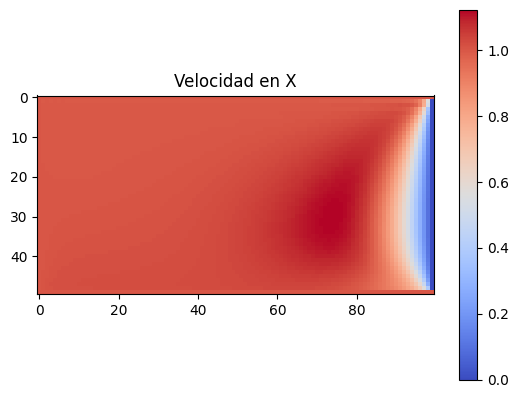

In [5]:
# Bucle principal de simulación (sin usar for)
for t in range(N):
    # Calcular la matriz b para la ecuación de Poisson
    b[1:-1, 1:-1] = (rho * (1 / dt * ((u[1:-1, 1:-1] - u[:-2, 1:-1]) / dx +
                                      (v[1:-1, 1:-1] - v[1:-1, :-2]) / dy) -
                            ((u[1:-1, 1:-1] * (u[1:-1, 1:-1] - u[:-2, 1:-1]) / dx) +
                             (v[1:-1, 1:-1] * (v[1:-1, 1:-1] - v[1:-1, :-2]) / dy))))

    # Resolver la ecuación de Poisson para la presión
    p = pressure_poisson(p, dx, dy, rho)

    # Actualizar velocidades
    u, v = update_velocities(u, v, p, dx, dy, dt, nu, rho)

# Visualizar los resultados
plt.imshow(u, cmap='coolwarm')
plt.colorbar()
plt.title('Velocidad en X')
plt.show()
